In [298]:
import numpy as np
import pandas as pd

import progressbar

import heapq
from collections import defaultdict

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import normalize

In [294]:
def euclidian_distance(x, y):
    return np.linalg.norm(x-y)

class NearestModel:
    def __init__(self, k):
        self.k = k
           
    def train(self, X, y):
        self.X = X
        self.y = y
    
    def predict(self, values):
        return [self.predict_one(v) for v in values]
    
    def predict_one(self, value):
        nearest = self._find_k_nearest(self.X, value, self.k)
        weights = defaultdict(lambda : 0.)
        
        for n in nearest:
            weights[self.y[n[1]]] += n[0]
        
        return max(weights, key=weights.get)
    
class KNN_model(NearestModel):
    def _find_k_nearest(self, data, x, k):
        data = sorted([(euclidian_distance(x, y), idx) for idx, y in enumerate(data)], key=lambda x: x[0])
        return [(1/(1+v[0]), v[1]) for v in data[:k]]
    
class RNN_model(NearestModel):
    def _find_k_nearest(self, data, x, r):
        data = [(euclidian_distance(x, y), idx) for idx, y in enumerate(data) if euclidian_distance(x, y) <= r]    
        return [(1/(1+v[0]), v[1]) for v in data]

In [295]:
def leave_one_out(model, X, y):
    correct = 0
    bar = progressbar.ProgressBar(widgets=[
    ' [', progressbar.Timer(), '] ', progressbar.Percentage(),
    progressbar.Bar(),
    ' (', progressbar.ETA(), ') ',
    ])
    for idx in bar(xrange(len(X))):
        X_test = X[idx]
        y_test = y[idx]
        
        X_train = np.delete(X, (idx), axis=0)
        y_train = np.delete(y, (idx), axis=0)
        
        model.train(X_train, y_train)
        res = model.predict_one(X_test)
        if res == y_test:
            correct += 1
    
    return 1.*correct/len(y)

In [296]:
data = pd.read_csv('spambase.csv')
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_:,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [273]:
X = data.drop(['label'], axis=1).as_matrix()
y = data['label'].as_matrix()

In [289]:
def compare_models(X, y, k_values):
    knn_res = list()
    rnn_res = list()
    sk_res = list()
    for k in k_values:
        print 'LOO for with k={}'.format(k)
        model = KNN_model(k)
        knn_acc = leave_one_out(model, X, Y)
        
        model = RNN_model(k*100)
        rnn_acc = leave_one_out(model, X, Y)
        
        sk_clf = KNeighborsClassifier(k)
        loo = LeaveOneOut()
        sk_acc = np.mean(cross_val_score(sk_clf, X, Y, cv = loo, n_jobs=4))
        
        knn_res.append(knn_acc)
        rnn_res.append(rnn_acc)
        sk_res.append(sk_acc)
    
    plt.plot(k_values, knn_res, label='knn model')
    plt.plot(k_values, rnn_res, label='rnn model')
    plt.plot(k_values, sk_res, label='scikit model')
    plt.legend()

LOO for with k=1


 [Elapsed Time: 0:03:34] 100%|###############################| (Time: 0:03:34) 
 [Elapsed Time: 0:04:55] 100%|###############################| (Time: 0:04:55) 


LOO for with k=2


 [Elapsed Time: 0:03:41] 100%|###############################| (Time: 0:03:41) 
 [Elapsed Time: 0:05:38] 100%|###############################| (Time: 0:05:38) 


LOO for with k=3


 [Elapsed Time: 0:03:41] 100%|###############################| (Time: 0:03:41) 
 [Elapsed Time: 0:05:59] 100%|###############################| (Time: 0:05:59) 


LOO for with k=4


 [Elapsed Time: 0:03:43] 100%|###############################| (Time: 0:03:43) 
 [Elapsed Time: 0:06:13] 100%|###############################| (Time: 0:06:13) 


LOO for with k=5


 [Elapsed Time: 0:03:44] 100%|###############################| (Time: 0:03:44) 
 [Elapsed Time: 0:06:29] 100%|###############################| (Time: 0:06:29) 


LOO for with k=6


 [Elapsed Time: 0:03:42] 100%|###############################| (Time: 0:03:42) 
 [Elapsed Time: 0:06:33] 100%|###############################| (Time: 0:06:33) 


LOO for with k=7


 [Elapsed Time: 0:03:42] 100%|###############################| (Time: 0:03:42) 
 [Elapsed Time: 0:06:43] 100%|###############################| (Time: 0:06:43) 


LOO for with k=8


 [Elapsed Time: 0:03:46] 100%|###############################| (Time: 0:03:46) 
 [Elapsed Time: 0:06:45] 100%|###############################| (Time: 0:06:45) 


LOO for with k=9


 [Elapsed Time: 0:03:44] 100%|###############################| (Time: 0:03:44) 
 [Elapsed Time: 0:06:42] 100%|###############################| (Time: 0:06:42) 


LOO for with k=10


 [Elapsed Time: 0:03:39] 100%|###############################| (Time: 0:03:39) 
 [Elapsed Time: 0:06:50] 100%|###############################| (Time: 0:06:50) 


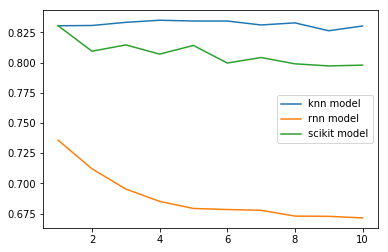

In [292]:
k_values = range(1, 11)
compare_models(X, y, k_values)

LOO for with k=1


 [Elapsed Time: 0:03:44] 100%|###############################| (Time: 0:03:44) 
 [Elapsed Time: 0:07:23] 100%|###############################| (Time: 0:07:23) 


LOO for with k=2


 [Elapsed Time: 0:03:46] 100%|###############################| (Time: 0:03:46) 
 [Elapsed Time: 0:07:27] 100%|###############################| (Time: 0:07:27) 


LOO for with k=3


 [Elapsed Time: 0:03:46] 100%|###############################| (Time: 0:03:46) 
 [Elapsed Time: 0:07:27] 100%|###############################| (Time: 0:07:27) 


LOO for with k=4


 [Elapsed Time: 0:03:44] 100%|###############################| (Time: 0:03:44) 
 [Elapsed Time: 0:07:21] 100%|###############################| (Time: 0:07:21) 


LOO for with k=5


 [Elapsed Time: 0:03:45] 100%|###############################| (Time: 0:03:45) 
 [Elapsed Time: 0:07:26] 100%|###############################| (Time: 0:07:26) 


LOO for with k=6


 [Elapsed Time: 0:03:47] 100%|###############################| (Time: 0:03:47) 
 [Elapsed Time: 0:07:23] 100%|###############################| (Time: 0:07:23) 


LOO for with k=7


 [Elapsed Time: 0:03:45] 100%|###############################| (Time: 0:03:45) 
 [Elapsed Time: 0:07:28] 100%|###############################| (Time: 0:07:28) 


LOO for with k=8


 [Elapsed Time: 0:03:37] 100%|###############################| (Time: 0:03:37) 
 [Elapsed Time: 0:07:15] 100%|###############################| (Time: 0:07:15) 


LOO for with k=9


 [Elapsed Time: 0:03:41] 100%|###############################| (Time: 0:03:41) 
 [Elapsed Time: 0:07:13] 100%|###############################| (Time: 0:07:13) 


LOO for with k=10


 [Elapsed Time: 0:03:40] 100%|###############################| (Time: 0:03:40) 
 [Elapsed Time: 0:07:10] 100%|###############################| (Time: 0:07:10) 


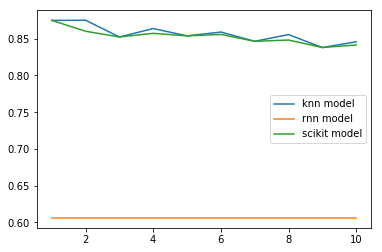

In [299]:
compare_models(normalize(X), y, k_values)